In [1]:
# Importing required packages
import numpy as np
import os
from sklearn import datasets

import sagemaker
from sagemaker import get_execution_role

# Preparing training image

## requirements.txt

lightgbm\
numpy\
pandas\

Just simple list of libriries required by your code\
You can also specify version with ==

## train.py

```
import lightgbm
import pandas as pd
import pickle

# Specifying paths

# Path to input data sets
input_path = '/opt/ml/input/data'
# Path to folder with model
model_path = '/opt/ml/model'
# Path to file with model hyperparameters
param_path = '/opt/ml/input/config/hyperparameters.json'

# Selecting channel type
train_channel_name = 'train'
test_channel_name = 'test'
# Selecting path to datasets
train_path = input_path + '/' + train_channel_name
test_path = input_path + '/' + test_channel_name

# Reading data
data_train = pd.read_csv(train_path + '/' + 'train.csv')
data_test = pd.read_csv(test_path + '/' + 'test.csv')
X = data_train.iloc[:, [0, 1, 2, 3]]
y = data_train.iloc[:, 4].values
X_test = data_test.iloc[:, [0, 1, 2, 3]]
y_test = data_test.iloc[:, 4].values

# Training model
model = lightgbm.LGBMRegressor()
model.fit(X, y)

# Saving data to folders from which this data will be uploaded to S3 bucket
with open(model_path + '/trained_model.pickle', 'wb') as f:
    pickle.dump(model, f)
predictions = model.predict(X_test)

with open(model_path + '/' + 'my_model_custom.pickle', 'wb') as f:
    pickle.dump(model, f)
```

Remember that only data from /output will be uploaded to your S3 bucket\
train\test_channel_name - names of your data channels which you specify in 'fit' method of your model

## Dockerfile

FROM python:3.7


COPY train.py /opt/ml/train.py

COPY requirements.txt .

RUN pip install --no-cache-dir -r requirements.txt

ENTRYPOINT ["python", "/opt/ml/train.py"]

FROM python:3.7 - selecting docker image. On top of this image we will build our image for model training

COPY train.py /opt/ml/train.py - copy file train.py (your python file in which you train your model) to specified path in your docker container\
You can copy as many files as you want, however you have to properly select directory in your docker container\

RUN pip install --no-cache-dir -r requirements.txt - installing libraries specified in requierements.txt with pip manager

ENTRYPOINT ... - specifying entrypoint to start training (Notice that you can't host your model on AWS with this code. I will modify this code in future, so it will be suited for training and hosting from 1 docker file)

SO you need:
1. Files to train your model
2. Dockerfile which will upload with files to specified directory in your docker image
3. File with required libraries

If you have this you can build your own docker image and upload it to AWS.\
If you don't have a clue about building docker images you can just create repository on [ECR](https://console.aws.amazon.com/ecr/repositories) and after creation check instructions on building image and pushing it to ECR

# Training your model

In [2]:
# S3 prefix
prefix = 'aws_example'
# Creating sagemmaker session
sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

In [3]:
# Load Iris dataset, then join labels and features
iris = datasets.load_iris()
joined_iris = np.insert(iris.data, 0, iris.target, axis=1)
# Saving data to csv file
np.savetxt('train.csv', joined_iris, delimiter=',', fmt='%1.1f, %1.3f, %1.3f, %1.3f, %1.3f')
np.savetxt('test.csv', joined_iris, delimiter=',', fmt='%1.1f, %1.3f, %1.3f, %1.3f, %1.3f')

In [4]:
# Uploading data to default S3 bucket
train_input = sagemaker_session.upload_data('train.csv', key_prefix="{}/train".format(prefix))
test_input = sagemaker_session.upload_data('test.csv', key_prefix="{}/test".format(prefix))

After uploading data to S3 bucket you can check it [here](https://s3.console.aws.amazon.com/s3/home)

Go to https://console.aws.amazon.com/ecr/repositories , select image with your model and copy link

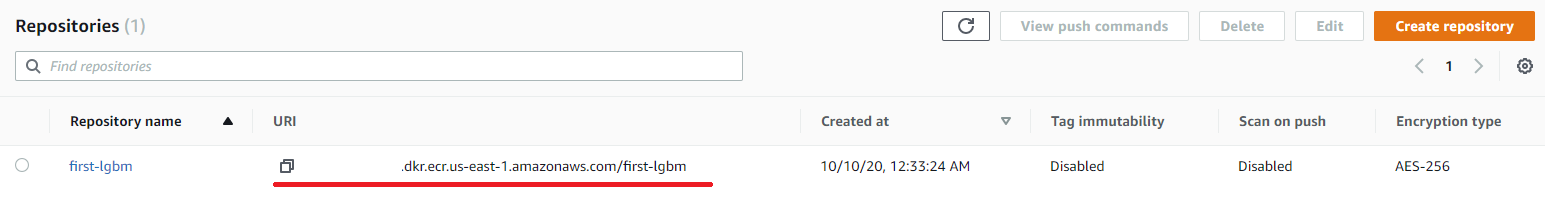

In [5]:
# Past copied link here. We will use this image to train model
image = '340325371232.dkr.ecr.us-east-2.amazonaws.com/first-lgbm'

In [6]:
train_input

's3://sagemaker-us-east-2-340325371232/aws_example/train/train.csv'

In [7]:
# Create an estimator
# image - link to image with your model on ECR
# role - role used by this notebook (check beginning of notebook)
# 1 - number of machines to run this code on
# ml.m4.xlarge - machine to train your model on
# output_path - link to s3 bucker where you want to save data generated by model (check output of train_input/test_input)
# sagemaker_session - current sagemaker session
clf = sagemaker.estimator.Estimator(image,
                                    role, 
                                    1, 
                                    'ml.m4.xlarge',
                                    output_path="s3://sagemaker-us-east-2-340325371232/aws_example/model",
                                    sagemaker_session = sagemaker_session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [8]:
# Fit estimator
# 'train' - name of first data channel
# 'test' - name of second data channel
clf.fit({'train' : train_input, 'test' : test_input})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-16 19:54:34 Starting - Starting the training job...
2020-10-16 19:54:36 Starting - Launching requested ML instances...
2020-10-16 19:55:33 Starting - Preparing the instances for training......
2020-10-16 19:56:32 Downloading - Downloading input data
2020-10-16 19:56:32 Training - Downloading the training image......
2020-10-16 19:57:33 Uploading - Uploading generated training model
2020-10-16 19:57:33 Completed - Training job completed
..Training seconds: 72
Billable seconds: 72
